# **FRONT END CODE**

In [1]:
! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.6 MB/s eta 0:00:00


In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%writefile app.py
import streamlit as st
from PIL import Image
import matplotlib.pyplot as plt


from fastai.vision.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.vision.core import *
from fastai import metrics
import scipy
from scipy import ndimage
from fastai.callback.core import Callback
import numpy as np
from scipy.ndimage import zoom
import cv2
from skimage import measure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load your data
depth_data = pd.read_csv('/content/drive/MyDrive/DATA_HAR/depth_values_with_houses.csv')

# Extract features and target
X_numeric = depth_data[['Num_Buildings', 'Num_Flooded']]
X_image_paths = depth_data['Image']
y = depth_data['Depth']

# Split the data into training and testing sets
X_numeric_train, X_numeric_test, X_image_train_paths, X_image_test_paths, y_train, y_test = train_test_split(
    X_numeric, X_image_paths, y, test_size=0.2, random_state=42
)

# Normalize numeric features
scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_test_scaled = scaler.transform(X_numeric_test)



y_global = None
x_global = None
num_houses_global = 0
num_flooded_global = 0


def count_flooded_houses(y, threshold=0.5):
    # Step 1: Thresholding
    binary_mask = y > threshold

    # Step 2: Connected Components
    labeled_mask, num_connected_components = measure.label(binary_mask, connectivity=2, return_num=True)

    # Step 3: Counting Houses
    num_houses_flooded = num_connected_components

    return num_houses_flooded



def tensor_to_np(tensor_img):
    # Convert tensor image to numpy array
    np_img = tensor_img.numpy()
    # Convert to uint8 and transpose if necessary
    if np_img.dtype == bool:
        np_img = (np_img * 255).astype(np.uint8)
    return np_img

# Define a custom callback to disable the progress bar
class DisableProgressCallback(Callback):
    def __init__(self):
        pass

    def before_validate(self):
        pass  # Disable progress bar for validation

    def after_validate(self):
        pass  # Do nothing during the after_validate event


def get_tuple_files(path):
    files = get_image_files(path)
    files = files.filter(lambda f: f.name.endswith('vhr.tif'),negate=False)
    return files

def label_func(x):
      return str(x.parents[0]/x.stem[0:23])+"_mask_build.tif";


# Load FastAI models (Assuming you have pre-trained models stored as `model_flood` and `model_build`)
model_build = load_learner(Path('/content/drive/My Drive/patch-building-again.pkl'),cpu = True)

model_flood = load_learner(Path('/content/drive/My Drive/patch-flooded-again.pkl'),cpu = True)

model_depth = load_learner(Path('/content/drive/My Drive/depth-again.pkl'),cpu = True)

model_build.remove_cb(ProgressCallback)
model_build.add_cb(DisableProgressCallback)
model_flood.remove_cb(ProgressCallback)
model_flood.add_cb(DisableProgressCallback)


model_depth.remove_cb(ProgressCallback)
model_depth.add_cb(DisableProgressCallback)


def main():
    st.title("Flood Mapping UI")

    # File uploader for image input
    uploaded_file = st.file_uploader("Select the map image", type=["jpg", "jpeg", "png", "tif"])

    if uploaded_file is not None:
        st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)

        # Button to process the image for segmentation
        st.subheader('Get all the Buildings', divider='rainbow')
        if st.button("Segment"):
            segment_image(uploaded_file)

        # Button to process the image for damaged segmentation
        st.subheader('Get all the Flooded Buildings', divider='rainbow')
        if st.button("Damaged Segment"):
            damaged_segment_image(uploaded_file)

        # Button to Calculate depth
        st.subheader('Calculate Average Depth', divider='rainbow')
        if st.button("Depth"):
            predictDepth(uploaded_file)


def visualize_houses(y, dot_diameter=2):
    # Convert PILMask to NumPy array
    y_np = np.array(y)

    # Step 1: Thresholding
    threshold = 0.5  # Adjust the threshold as needed
    binary_mask = (y_np > threshold).astype(np.uint8)

    # Step 2: Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 3: Create an RGBA image with red dots representing houses on a transparent background
    house_image = np.zeros((*y_np.shape, 4), dtype=np.uint8)
    house_image[:, :, 3] = 0  # Set alpha channel to 0 (transparent)

    for contour in contours:
        # Get the centroid of each contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            # Draw a red dot at the centroid
            cv2.circle(house_image, (cx, cy), dot_diameter, (255, 0, 0, 255), -1)

    # Convert NumPy array to PIL image
    house_image_pil = Image.fromarray(house_image)

    return house_image_pil



def segment_image(uploaded_file):
    st.write("BUILDINGS")
    im = PILImage.create(uploaded_file)

    # Assuming you need to split the image into smaller segments
    z = im.reshape(1024, 1024, resample=Image.BICUBIC)
    z = image2tensor(z)
    z1 = z[:, 0:512, 0:512]
    z2 = z[:, 0:512, 512:1024]
    z3 = z[:, 512:1024, 0:512]
    z4 = z[:, 512:1024, 512:1024]

    z1 = z1.permute((1, 2, 0))
    z2 = z2.permute((1, 2, 0))
    z3 = z3.permute((1, 2, 0))
    z4 = z4.permute((1, 2, 0))

    im1 = PILImage.create(z1.cpu().numpy())
    im2 = PILImage.create(z2.cpu().numpy())
    im3 = PILImage.create(z3.cpu().numpy())
    im4 = PILImage.create(z4.cpu().numpy())

    x1 = torch.cat([model_build.predict(im1)[0], model_build.predict(im2)[0]], dim=1)
    x2 = torch.cat([model_build.predict(im3)[0], model_build.predict(im4)[0]], dim=1)
    x = torch.cat([x1, x2], dim=0)
    x_global = x


    # Convert the tensor image to numpy array
    np_img = tensor_to_np(x)

    # Display the segmented image using pyplot and st.pyplot()
    fig, ax = plt.subplots()
    ax.imshow(np_img)
    ax.set_title('Segmented Image')
    ax.axis('off')  # Optional: Turn off axis if not needed
    st.pyplot(fig)

    #counting all houses
    num_houses = count_flooded_houses(x)
    num_houses_global = num_houses
    st.write(f'Total Number of Houses : {num_houses}')


def damaged_segment_image(uploaded_file):
    st.write("DAMAGED BUILDINGS")
    im = PILImage.create(uploaded_file)

    # Assuming you need to split the image into smaller segments
    # Adjust this part according to your actual requirements
    z = im.reshape(1024, 1024, resample=Image.BICUBIC)
    z = image2tensor(z)
    z1 = z[:, 0:512, 0:512]
    z2 = z[:, 0:512, 512:1024]
    z3 = z[:, 512:1024, 0:512]
    z4 = z[:, 512:1024, 512:1024]

    z1 = z1.permute((1, 2, 0))
    z2 = z2.permute((1, 2, 0))
    z3 = z3.permute((1, 2, 0))
    z4 = z4.permute((1, 2, 0))

    im1 = PILImage.create(z1.cpu().numpy())
    im2 = PILImage.create(z2.cpu().numpy())
    im3 = PILImage.create(z3.cpu().numpy())
    im4 = PILImage.create(z4.cpu().numpy())

    model_flood.progress = False
    y1 = torch.cat([model_flood.predict(im1)[0], model_flood.predict(im2)[0]], dim=1)
    y2 = torch.cat([model_flood.predict(im3)[0], model_flood.predict(im4)[0]], dim=1)
    y = torch.cat([y1, y2], dim=0)
    y_global = y

    # Convert the tensor image to numpy array
    np_img = tensor_to_np(y)

    im_resized = zoom(im, (y.shape[0] / im.shape[0], y.shape[1] / im.shape[1], 1), order=3)

    # Display the VHR image with the mask overlaid
    fig, axarr = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True)
    axarr.imshow(im_resized)
    axarr.imshow(y, alpha=0.5, cmap='viridis')  # Adjust alpha as needed
    axarr.set_title('VHR Image with Flooded Building Mask')

    # Display the plot using Streamlit
    st.pyplot(fig)

    #counting Flooded Houses
    num_houses_flooded = count_flooded_houses(y)
    num_flooded_global = num_houses_flooded
    st.write(f'Total Number of Houses Flooded : {num_houses_flooded}')



def depthInFeet(inp):
  min_depth_dataset = 0.0
  max_depth_dataset = 10.0

  # Desired range for depth representation (0 to 10 feet)
  min_depth_desired = 0  # Minimum depth in feet
  max_depth_desired = 10  # Maximum depth in feet

  # Convert the predicted depth value to the desired range
  predicted_depth = inp  # Example: Predicted depth value from the model

  # Scale the predicted depth value from the dataset range to the desired range
  scaled_depth = (predicted_depth - min_depth_dataset) * (max_depth_desired - min_depth_desired) / (max_depth_dataset - min_depth_dataset) + min_depth_desired

  # Display the scaled depth value
  return scaled_depth


# Define a function to process uploaded image
def process_uploaded_image(uploaded_file, target_shape=(224, 224, 3)):
    image = Image.open(uploaded_file)
    img_array = np.array(image)

    # Check the shape of the image
    if img_array.shape != target_shape:
        # Resize the image to the target shape
        img_array = cv2.resize(img_array, (target_shape[1], target_shape[0]))

    # Perform any additional preprocessing steps here

    return img_array

# Define a function to make predictions
def make_prediction(image, numeric_data, model_depth):
    # Check if the image has an extra dimension and squeeze it if necessary
    if len(image.shape) == 4 and image.shape[0] == 1:
        image = np.squeeze(image, axis=0)

    # Convert image to the appropriate format
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'))
    elif not isinstance(image, PIL.Image.Image):
        raise AssertionError(f"Expected image of type numpy.ndarray or PIL.Image.Image, but got {type(image)}")

    # Load scaler if needed
    scaled_numeric_data = scaler.transform(numeric_data.reshape(1, -1))  # Scale numeric data

    # Make a prediction using the model
    prediction = model_depth.predict(image)

    return prediction


def predictDepth(uploaded_file):
    # Example input values
    example_num_houses = num_houses_global
    example_num_flooded = num_flooded_global

    # Process the example image
    example_image = process_uploaded_image(uploaded_file)
    example_image = np.expand_dims(example_image, axis=0)

    # Normalize numeric features
    example_numeric = np.array([[example_num_houses, example_num_flooded]])
    example_numeric_scaled = scaler.transform(example_numeric)

    # Make a prediction using the model
    prediction = make_prediction(example_image, example_numeric_scaled, model_depth)

    predicted_depth = prediction[2][-1].item()

    new_depth = depthInFeet(predicted_depth)
    st.write(f'New Depth: {new_depth*100}')

main()

Writing app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸

⠼⠴⠦⠧⠇⠏
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.29.162.37:8501

Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦your url is: https://cute-hairs-end.loca.lt


# **BUILDIG MODEL TRAINING CODE**

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
print(torch.cuda.is_available())

In [ ]:
from fastai.vision.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.vision.core import *
from fastai import metrics
torch.cuda.get_device_properties(0).total_memory

In [ ]:
path=Path("/content/drive/My Drive/DATA_HAR")

In [ ]:
#DATA BLOCK AND LOADER
def get_tuple_files(path):
    files = get_image_files(path)
    files = files.filter(lambda f: f.name.endswith('vhr.tif'),negate=False)
    return files


In [ ]:
def label_func(x):
      return str(x.parents[0]/x.stem[0:23])+"_mask_build.tif";

In [ ]:
 seg = DataBlock(blocks=(ImageBlock(), MaskBlock( codes =['n','y'])),

    item_tfms=[Resize(512,method='squish',resamples=(Image.BICUBIC,Image.BICUBIC)),ToTensor],
    batch_tfms=[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)],

    get_items=get_tuple_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func)


In [ ]:
seg.summary(path)

In [ ]:
dls = seg.dataloaders(path,bs=8)
dls.show_batch()

In [ ]:
b = dls.one_batch()

In [ ]:
plt.imshow(b[0][0][2].cpu().numpy())

In [ ]:
plt.imshow(b[1][0].cpu().numpy())

In [ ]:
learn= unet_learner(dls,resnet34, metrics=[Dice()])

learn.summary()

In [ ]:
learn.fine_tune(6,base_lr=2e-3)

In [ ]:
learn.save("patch-build-again")

Path('models/patch-build-again.pth')

In [ ]:
learn.export("patch-building-again.pkl")

In [ ]:
learn.export("/content/drive/My Drive/patch-building-again.pkl")

In [ ]:
learn.export("/content/drive/My Drive/patch-build-again.pth")

# **FLOOD MODEL TRAINING CODE**

In [ ]:
def get_tuple_files(path):
    files = get_image_files(path)
    files = files.filter(lambda f: f.name.endswith('vhr.tif'),negate=False)
    return files


In [ ]:
def label_func(x):
      return str(x.parents[0]/x.stem[0:23])+"_mask_flood.tif";

In [ ]:
 seg = DataBlock(blocks=(ImageBlock(), MaskBlock( codes =['n','y'])),

    item_tfms=[Resize(512,method='squish',resamples=(Image.BICUBIC,Image.BICUBIC)),ToTensor],
    batch_tfms=[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)],

    get_items=get_tuple_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func)


In [ ]:
seg.summary(path)

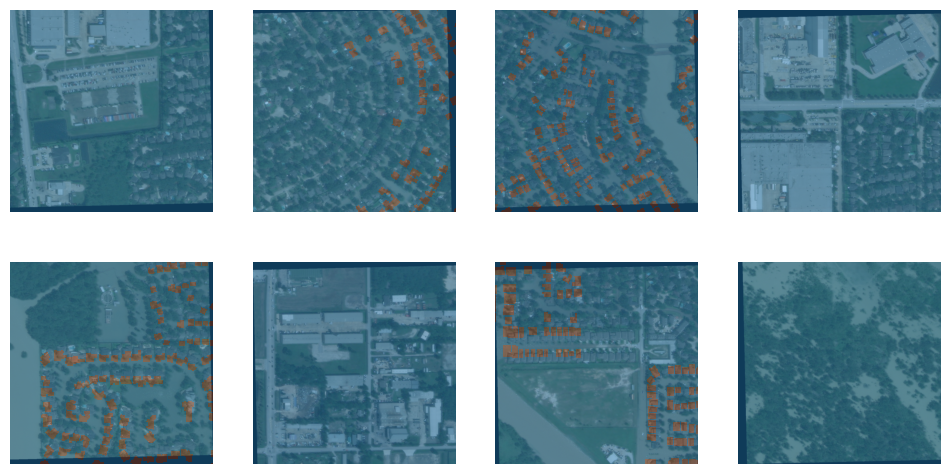

In [ ]:
dls = seg.dataloaders(path,bs=8)
dls.show_batch()

In [ ]:
b = dls.one_batch()

In [ ]:
plt.imshow(b[0][0][2].cpu().numpy())

In [ ]:
plt.imshow(b[1][0].cpu().numpy())

In [ ]:
learn= unet_learner(dls,resnet34, metrics=[Dice()])

learn.summary()

In [ ]:
import os

file_path = 'models/patch-build-again.pth'
if os.path.exists(file_path):
    print(f"The file {file_path} exists.")
else:
    print(f"The file {file_path} does not exist.")

In [ ]:
learn.load("/content/drive/MyDrive/patch-build-again")

In [ ]:
learn.fine_tune(5,base_lr=2e-3)

In [ ]:
learn.save("patch-flood-again")

In [ ]:
learn.export("/content/drive/My Drive/patch-flooded-again.pkl")

# **CONSTRUCTION OF DEPTH_CSV CODE**

In [ ]:
from pathlib import Path
import pandas as pd
from fastai.vision.all import *
import matplotlib.pyplot as plt
import time

# Set your path
path = Path("/content/drive/My Drive/DATA_HAR")

# Create a list to store depth values
depth_values = []
count = 200
# Loop for 200 images
for file in get_image_files(path).filter(lambda f: f.name.endswith('vhr.tif'), negate=False):
    # Display the image using Matplotlib

    im = PILImage.create(file)
    plt.imshow(im)
    plt.show()

    time.sleep(2)

    print("\n\n\n\n")
    # User input for depth value
    depth = float(input(f"Enter depth "))
    depth_values.append({'Image': file.name, 'Depth': depth})
    count += -1
    if(count == 0):
      break

# Create a DataFrame and save to CSV
df = pd.DataFrame(depth_values)
df.to_csv(path/'depth_values.csv', index=False)


# **DEPTH MODEL TRAINING CODE**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
import cv2
import os

# Function to load and preprocess images
def process_image(image_name, data_directory, target_shape=(224, 224, 3)):
    # Construct the full path to the image
    image_path = os.path.join(data_directory, image_name)

    # Read the image
    img = cv2.imread(image_path)

    # Check the shape of the image
    if img.shape != target_shape:
        # Resize the image to the target shape
        img = cv2.resize(img, (target_shape[1], target_shape[0]))

    # Perform any additional preprocessing steps here

    return img

# Load your data
depth_data = pd.read_csv('/content/drive/MyDrive/DATA_HAR/depth_values_with_houses.csv')

# Extract features and target
X_numeric = depth_data[['Num_Buildings', 'Num_Flooded']]
X_image_paths = depth_data['Image']
y = depth_data['Depth']

# Split the data into training and testing sets
X_numeric_train, X_numeric_test, X_image_train_paths, X_image_test_paths, y_train, y_test = train_test_split(
    X_numeric, X_image_paths, y, test_size=0.2, random_state=42
)

# Normalize numeric features
scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_test_scaled = scaler.transform(X_numeric_test)

# Create the image processing model using ResNet50
def build_image_model(input_shape=(224, 224, 3)):
    input_image = Input(shape=input_shape)
    base_model = ResNet50(input_tensor=input_image, include_top=False, weights='imagenet')
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    return Model(inputs=input_image, outputs=x)

# Create the numeric features model
def build_numeric_model(input_shape=(2,)):
    input_numeric = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input_numeric)
    x = Dropout(0.5)(x)
    return Model(inputs=input_numeric, outputs=x)

# Combine the image and numeric models
image_model = build_image_model()
numeric_model = build_numeric_model()

combined_model = Concatenate()([image_model.output, numeric_model.output])
x = Dense(32, activation='relu')(combined_model)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[image_model.input, numeric_model.input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Inside your training loop or data preprocessing step
data_directory = '/content/drive/MyDrive/selected_images'  # Replace with the actual directory path

X_image_train_processed = np.array([process_image(name, data_directory) for name in X_image_train_paths])
X_image_test_processed = np.array([process_image(name, data_directory) for name in X_image_test_paths])

# Train the model
model.fit([X_image_train_processed, X_numeric_train_scaled], y_train,
          validation_data=([X_image_test_processed, X_numeric_test_scaled], y_test),
          epochs=20, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate([X_image_test_processed, X_numeric_test_scaled], y_test)
print(f'Mean Squared Error on Test Data: {loss}')